# Intro

When learning the zenith equations, we will need to interpolate between the observations of Ozone. For this we must develop a regression model for the Ozone time-series. The problem is set up as follows:
1. We have observations of Oz at discrete time stamps
2. We have a new time stamp which is not among the observations, but is within the observed interval
3. Using apprpriate technique, find the value of Oz at that time stamp and assess unerctainty.

**Note:**
1. We will ignore geo-location for now and treat the entire time series of Ozone as measured at the same location
2. We will focus on OZCD

In [120]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# from scipy import interpolate
from pathlib import Path
from pprint import pprint
from copy import deepcopy
import operator

import dill

from pprint import pprint, pp

from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import (
    StandardScaler,
    PolynomialFeatures,
)
from sklearn.pipeline import make_pipeline
from sklearn.dummy import DummyRegressor

import seaborn as sns
from tqdm.notebook import tqdm

import itertools
import functools


# test-train split
from sktime.forecasting.model_selection import temporal_train_test_split

# # plotter
from sktime.utils.plotting import plot_series

# # forecasting horizon
from sktime.forecasting.base import ForecastingHorizon 

# # performanc metric 
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error

# # FORECASTERS

# # list of available forecasters
from sktime.registry import all_estimators

from sktime.forecasting.naive import NaiveForecaster
# from sktime.forecasting.theta import ThetaForecaster
from sktime.forecasting.ets import AutoETS


# from sktime.forecasting.arima import ARIMA
# from sktime.forecasting.arima import AutoARIMA

from sktime.forecasting.fbprophet import Prophet

# Load and view data

In [3]:
df_direct = pd.read_pickle("df_direct.pkl")
df_zenith = pd.read_pickle("df_zenith.pkl")

df = pd.DataFrame(index = df_direct['dt'], columns = ['OZCD'])
df = df_direct.drop(columns = 'Unnamed: 0').set_index('dt')
df.index.name = None
df['OZCD'] = df['OZCD'].astype(float)

# the following needs some investigation: 2 rows are somehow being flagged as duplicates
# for now, just chuck them

df = df['OZCD'][~df.index.duplicated()]

Plot without tie gaps between observations

**Note: This is a useless and misleading plot, because we clearly have missing seasonal observations in 2018-2020, which are jammed together**

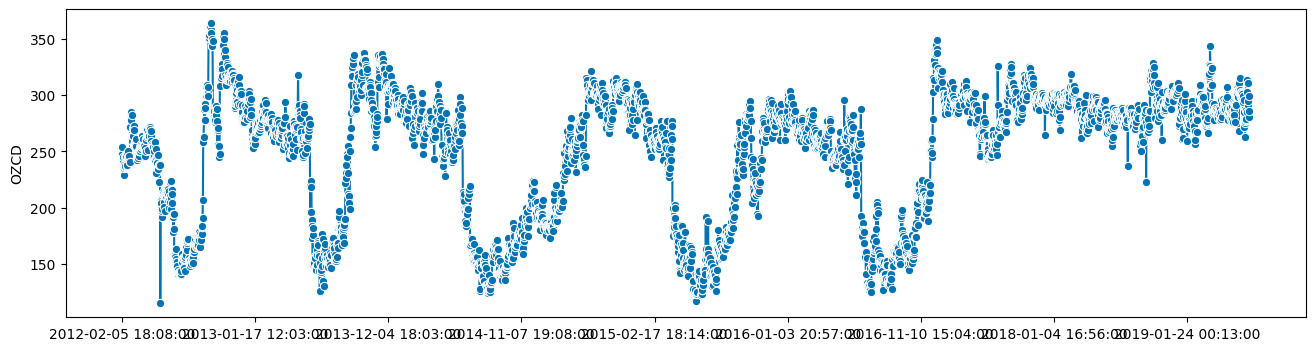

In [4]:
plot_series(df);

Plot on actual time arrow

**This is revealing of trends**

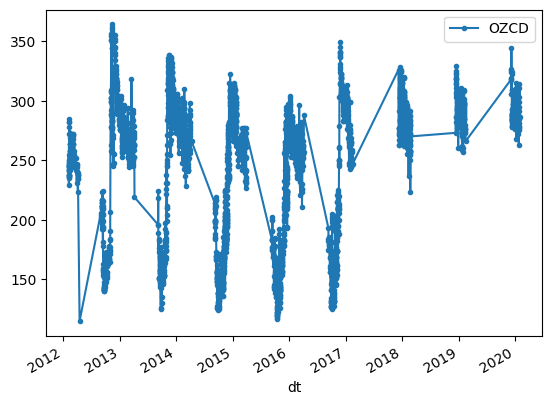

In [5]:
df_direct.plot('dt', 'OZCD', style = '.-');

# Rescale time arrow

We need to rescale to a manageable interval, say [0, 1]. 

We have about 8 years of observations and time stamps have minute resolution, i.e. we have 
$$\approx8\cdot365\cdot24\cdot60=4204800\approx 5\cdot10^6$$
minutes. And observations take place at some of those minutes. 

Let's cast in terms of minutes and rescale

In [6]:
from datetime import datetime, date, time, timedelta

In [7]:
df = df\
.reset_index()\
.rename(columns = {'index':'t', 'OZCD':'x'})

In [10]:
df

,t,x
0,2012-02-05 18:08:00,248.0
1,2012-02-05 19:36:00,254.0
2,2012-02-06 14:51:00,238.0
3,2012-02-06 16:35:00,242.0
4,2012-02-06 17:35:00,245.0
...,...,...
3383,2020-01-29 09:24:00,311.0
3384,2020-01-29 12:12:00,295.0
3385,2020-01-29 18:00:00,299.0
3386,2020-01-29 22:00:00,281.0


In [11]:
t0 = df['t'].iloc[0].to_pydatetime()
tN = df['t'].iloc[-1].to_pydatetime()

In [14]:
dtN = (tN-t0).total_seconds()/60.

In [15]:
df['dt']=df['t'].apply(lambda x: (x.to_pydatetime()-t0).total_seconds()/60./dtN)

In [16]:
df

,t,x,dt
0,2012-02-05 18:08:00,248.0,0.000000
1,2012-02-05 19:36:00,254.0,0.000021
2,2012-02-06 14:51:00,238.0,0.000296
3,2012-02-06 16:35:00,242.0,0.000321
4,2012-02-06 17:35:00,245.0,0.000335
...,...,...,...
3383,2020-01-29 09:24:00,311.0,0.999657
3384,2020-01-29 12:12:00,295.0,0.999697
3385,2020-01-29 18:00:00,299.0,0.999780
3386,2020-01-29 22:00:00,281.0,0.999837


## Convert from [0,1] to date-time

In [30]:
def roundTime(dt=None, roundTo=60):
   """Round a datetime object to any time lapse in seconds
   dt : datetime.datetime object, default now.
   roundTo : Closest number of seconds to round to, default 1 minute.
   Author: Thierry Husson 2012 - Use it as you want but don't blame me.
   """
   seconds = (dt.replace(tzinfo=None) - dt.min).seconds
   rounding = (seconds+roundTo/2) // roundTo * roundTo
   return dt + timedelta(0,rounding-seconds,-dt.microsecond)

In [31]:
# to get back date from a random iota in [0,1]
iota = np.random.uniform()
t_iota = t0+timedelta(minutes = iota*dtN)
t_iota

datetime.datetime(2013, 8, 27, 2, 20, 42, 982736)

In [32]:
roundTime(t_iota)

datetime.datetime(2013, 8, 27, 2, 21)

datetime.datetime(2012, 2, 5, 19, 40)

## Querry points

Our querry points are times of zenith measurements. Let's place them on our time scale

In [113]:
# get zenith times within direct time frame
ind_zenith= ((df_zenith.dt>df['t'].iloc[0]) & (df_zenith.dt<df['t'].iloc[-1]))

In [114]:
date_zen = df_zenith.dt[ind_zenith]\
.reset_index()\
.drop(columns = 'index')\
.rename(columns = {'dt':'t'})
date_zen['dt']=date_zen['t'].apply(lambda x: (x.to_pydatetime()-t0).total_seconds()/60./dtN)
date_zen

,t,dt
0,2012-02-05 19:40:00,0.000022
1,2012-02-06 08:36:00,0.000207
2,2012-02-06 09:59:00,0.000227
3,2012-02-06 13:00:30,0.000270
4,2012-02-06 14:55:30,0.000297
...,...,...
66455,2020-01-30 09:00:00,0.999994
66456,2020-01-30 09:05:00,0.999995
66457,2020-01-30 09:10:00,0.999997
66458,2020-01-30 09:15:00,0.999998


0        0.000022
10       0.000593
20       0.000908
30       0.001314
40       0.001706
           ...   
66410    0.999941
66420    0.999953
66430    0.999965
66440    0.999976
66450    0.999988
Name: dt, Length: 6646, dtype: float64

Quick check with conversion back to date:

In [124]:
roundTime(t0+timedelta(minutes = tq[2]*dtN))

datetime.datetime(2012, 2, 6, 9, 59)

In [125]:
tq = date_zen['dt'].values
tq.shape

(66460,)

To appreciate the amounts of data, let's plot known measurements and querry points on a small interval within the timeframe

(0.85, 0.89)

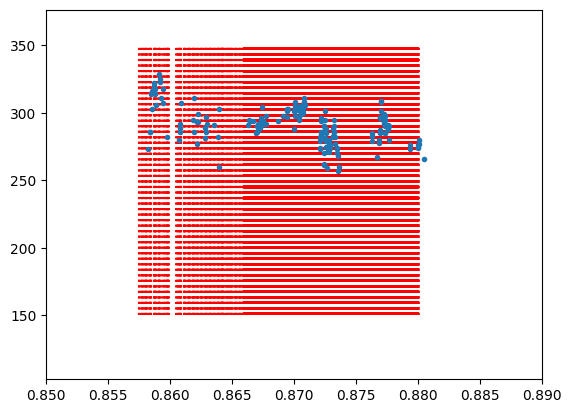

In [116]:
%matplotlib inline
plt.vlines(tq[(tq>.85) & (tq<.88)], 150., 350., colors = 'r', linestyles = ':');
# plt.scatter(tq, 150.*np.ones(tq.shape), .5, color = 'r')
plt.plot(df.dt, df.x, '.')
plt.xlim([.85, .89])

## Save rescaled Ozone-CD data and querry pts



In [126]:
t_ozone = df.dt
x_ozone = df.x
t_querry = tq

In [128]:
with open('ozcd_rescaled.pkl', 'wb') as dill_file:
    dill.dump((t_ozone, x_ozone, t_querry), dill_file)

In [256]:
t_ozone.to_csv('t_ozone.csv')
x_ozone.to_csv('x_ozone.csv')
date_zen['dt'].to_csv('t_querry.csv')

In [259]:
df.to_csv('ozone_df.csv')

In [250]:
x_ozone

0       248.0
1       254.0
2       238.0
3       242.0
4       245.0
        ...  
3383    311.0
3384    295.0
3385    299.0
3386    281.0
3387    286.0
Name: x, Length: 3388, dtype: float64

# Try seasonal models with maximal likelihood fitting

These are basic, and don't provide uncertainty quantification. But we will get a feel for what works and implement it probabilistically with MCMC. 

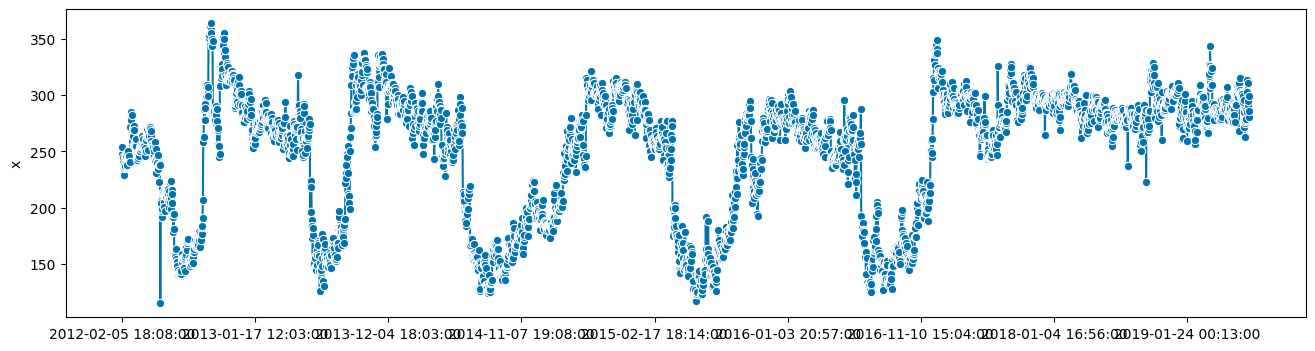

In [185]:
df0 = df[['t', 'x']].set_index('t').squeeze()

# querry dates
fh1 = ForecastingHorizon(pd.DatetimeIndex(date_zen['t'][::100]), is_relative=False)

plot_series(df0);

In [243]:
# from sktime.regression.interval_based import TimeSeriesForestRegressor

## Prophet

In [186]:
forecaster = Prophet(
    growth = 'linear',
    seasonality_mode='additive',
    seasonality_prior_scale = 1.,
    mcmc_samples=0,
    n_changepoints = 40,
    changepoint_range = .3,
    weekly_seasonality=False,
    daily_seasonality=False,
    yearly_seasonality=True)


In [187]:
forecaster.fit(df0)

/Users/peteryatsyshin/opt/anaconda3/envs/xeus/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Prophet(changepoint_range=0.3, daily_seasonality=False, n_changepoints=40,
        seasonality_prior_scale=1.0, weekly_seasonality=False,
        yearly_seasonality=True)

In [188]:
y = forecaster.predict(fh1)

/Users/peteryatsyshin/opt/anaconda3/envs/xeus/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


/Users/peteryatsyshin/opt/anaconda3/envs/xeus/lib/python3.8/site-packages/sktime/utils/validation/series.py:248: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  return type(index) in (pd.Int64Index, pd.RangeIndex)


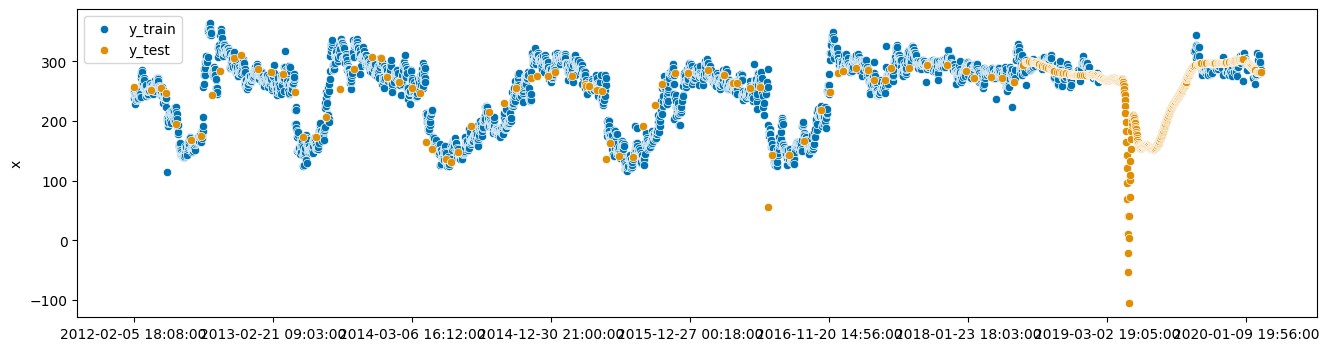

In [189]:
plot_series(df0,y,
            labels=["y_train", "y_test"]);